In [1]:
from sklearn.metrics import mutual_info_score
#from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
import seaborn as sns
import pandas as pd

# Mathematical Underpinnings - Lab 5

Tests to verify hipoteses of independence (from Lab 4):

In [2]:
def indep_test_asymptotic(X, Y, stat):

    if stat == "mi":

        stat_value = 2*len(X)*mutual_info_score(X, Y)

    if stat == "chi2":

        test_res = (chi2_contingency(pd.crosstab(X, Y)))
        stat_value = test_res.statistic

    df = (len(np.unique(X)) - 1)*(len(np.unique(Y)) - 1)

    p_value = 1 - chi2.cdf(stat_value, df=df)

    return stat_value, p_value

def indep_test_permutation(X, Y, B, stat="mi"):

    stat_value = mutual_info_score(X, Y)

    condition_p_value = 0
    for b in range(B):
        X_b = np.random.permutation(X)

        stat_value_b = mutual_info_score(X_b, Y)

        if stat_value <= stat_value_b:
            condition_p_value += 1

    p_value = (1 + condition_p_value)/(1 + B)

    return 2*len(X)*stat_value, p_value

In [3]:
x = np.array([0, 1, 1, 2, 3, 3, 3])
y = np.array([0, 0, 1, 1, 1, 1, 3])
# get contingency table
contingency = pd.crosstab(x, y)
contingency

col_0,0,1,3
row_0,,,
0,1,0,0
1,1,1,0
2,0,1,0
3,0,2,1


## Task 1

In [4]:
def mutual_info_score(x, y, bins=10):
    contingency = pd.crosstab(x, y).values
    contingency = contingency / np.sum(contingency)
    current_sum = 0
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            if contingency[i, j] != 0:
                current_sum += contingency[i, j] * np.log(
                    contingency[i, j] / (np.sum(contingency[i, :]) * np.sum(contingency[:, j]))
                )
    return current_sum

def conditional_mututal_info_score(x, y, z):

    unique_z_values = np.unique(z)
    prob_z_values = np.array([np.sum(z == z_value) for z_value in unique_z_values]) / len(z)
    cmi_score = 0 

    for i, z_value in enumerate(unique_z_values):
        x_z = x[z == z_value]
        y_z = y[z == z_value]
        cmi_score += mutual_info_score(x_z, y_z) * prob_z_values[i]

    return cmi_score

### a)

In [5]:
def asymptotic_conditional_independence_test(x, y, z): 
    cmi = conditional_mututal_info_score(x, y, z)
    n = len(x)
    stat_value = 2*n*cmi
    df = (len(np.unique(x)) - 1)*(len(np.unique(y)) - 1)*len(np.unique(z))
    p_value = 1 - chi2.cdf(stat_value, df=df)
    return stat_value, p_value

### b)

In [6]:
def conditional_permute(x, z): 
    unique_z_values = np.unique(z)
    x_copy = x.copy()
    for z_value in unique_z_values: 
        x_copy[z == z_value] = np.random.permutation(x_copy[z == z_value])
    return x_copy

def permutation_conditional_independence_test(x, y, z, B=1000):
    cmi = conditional_mututal_info_score(x, y, z)
    n = len(x)
    stat_value = 2*n*cmi
    counter = 0
    for _ in range(B): 
        x_b = conditional_permute(x, z)
        cmi_b = conditional_mututal_info_score(x_b, y, z)
        if cmi <= cmi_b: 
            counter += 1
    p_value = (1 + counter) / (1 + B)
    return stat_value, p_value

### c)

In [7]:
def discretize_pos_neg(vector):
    res = np.ones(len(vector))
    res[vector < 0] = -1
    return res

**conditionaly independent**

In [8]:
n = 2000
Z_tilde = np.random.uniform(-1, 1, n)
Z = discretize_pos_neg(Z_tilde)
X_tilde = np.random.normal(Z/2, 1, n)
Y_tilde = np.random.normal(Z/2, 1, n)
X = discretize_pos_neg(X_tilde)
Y = discretize_pos_neg(Y_tilde)

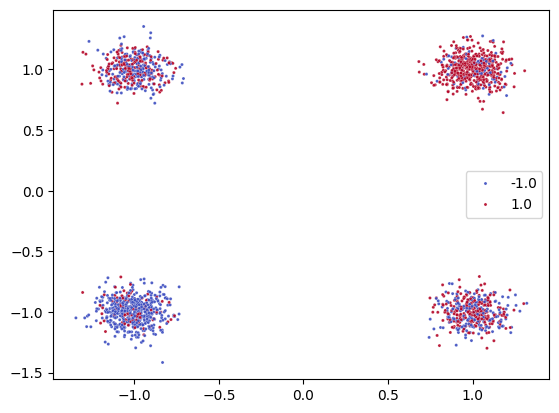

In [9]:
X_noisy = X + np.random.normal(0, 0.1, n)
Y_noisy = Y + np.random.normal(0, 0.1, n)
sns.scatterplot(x=X_noisy, y=Y_noisy, alpha=0.9, s=5, hue=Z, palette="coolwarm")
plt.show()

In [10]:
pd.DataFrame({"X": X, "Y": Y, "Z": Z}).groupby(["Z", "X", "Y"]).size()

Z     X     Y   
-1.0  -1.0  -1.0    497
             1.0    221
       1.0  -1.0    196
             1.0     87
 1.0  -1.0  -1.0     90
             1.0    199
       1.0  -1.0    231
             1.0    479
dtype: int64

In [11]:
asymptotic_conditional_independence_test(X, Y, Z)

(0.18359340046337924, 0.9122905991609609)

In [12]:
permutation_conditional_independence_test(X, Y, Z)

(0.18359340046337924, 0.913086913086913)

**conditionaly dependent** (but independent unconditionally)

In [13]:
X_tilde = np.random.uniform(-1, 1, n)
Y_tilde = np.random.uniform(-1, 1, n)
X = discretize_pos_neg(X_tilde)
Y = discretize_pos_neg(Y_tilde)
Z_tilde = np.random.normal(0, 1, n) + (X + Y)/2
Z = discretize_pos_neg(Z_tilde)

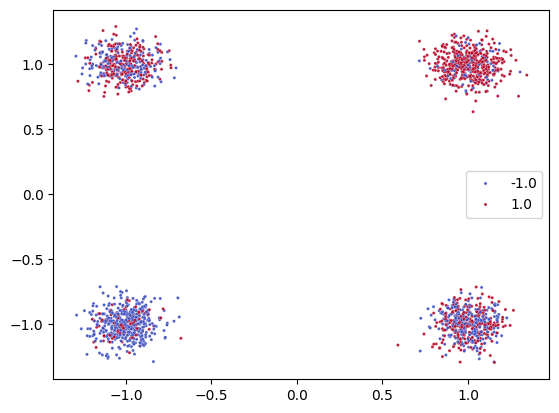

In [14]:
X_noisy = X + np.random.normal(0, 0.1, n)
Y_noisy = Y + np.random.normal(0, 0.1, n)
sns.scatterplot(x=X_noisy, y=Y_noisy, alpha=0.9, s=5, hue=Z, palette="coolwarm")
plt.show()

In [15]:
pd.DataFrame({"X": X, "Y": Y, "Z": Z}).groupby(["Z", "X", "Y"]).size()

Z     X     Y   
-1.0  -1.0  -1.0    417
             1.0    214
       1.0  -1.0    273
             1.0     81
 1.0  -1.0  -1.0     86
             1.0    245
       1.0  -1.0    241
             1.0    443
dtype: int64

In [16]:
asymptotic_conditional_independence_test(X, Y, Z)

(22.426069254981222, 1.3497114616289885e-05)

In [17]:
permutation_conditional_independence_test(X, Y, Z)

(22.426069254981222, 0.000999000999000999)

In [18]:
indep_test_asymptotic(X, Y, "mi")

(1.5314890328583728, 0.21588910496340918)

In [19]:
indep_test_asymptotic(X, Y, "chi2")

(1.4224832017636522, 0.23299511233041315)

## Task 2

In [20]:
def discretize_pos_neg(vector):
    res = np.ones(len(vector))
    res[vector < 0] = -1
    return res

def sample_from_model1(n):
    Z_tilde = np.random.normal(0, 1, n)
    Z = discretize_pos_neg(Z_tilde)
    X_tilde = np.random.normal(Z/2, 1, n)
    Y_tilde = np.random.normal(Z/2, 1, n)
    X = discretize_pos_neg(X_tilde)
    Y = discretize_pos_neg(Y_tilde)
    return X, Y, Z

def sample_from_model2(n):
    X_tilde = np.random.normal(0, 1, n)
    X = discretize_pos_neg(X_tilde)
    Z_tilde = np.random.normal(0, 1, n) + X/2
    Z = discretize_pos_neg(Z_tilde)
    Y_tilde = np.random.normal(0, 1, n) + Z/2
    Y = discretize_pos_neg(Y_tilde)
    return X, Y, Z

def sample_from_model3(n):
    X_tilde = np.random.normal(0, 1, n)
    Y_tilde = np.random.normal(0, 1, n)
    X = discretize_pos_neg(X_tilde)
    Y = discretize_pos_neg(Y_tilde)
    Z_tilde = np.random.normal(0, 1, n) + (X + Y)/2
    Z = discretize_pos_neg(Z_tilde)
    return X, Y, Z

### a)

answer:

- model 1 - dependent unconditionally, independent conditionaly on Z 
- model 2 - dependent unconditionally, independent conditionaly on Z
- model 3 - independent unconditionally, dependent conditionaly on Z

### b)

In [21]:
X_1, Y_1, Z_1 = sample_from_model1(1000)
mutual_info_score(X_1, Y_1), conditional_mututal_info_score(X_1, Y_1, Z_1)

(0.005320831965835462, 0.00060002073097211)

In [22]:
X_2, Y_2, Z_2 = sample_from_model2(1000)
mutual_info_score(X_2, Y_2), conditional_mututal_info_score(X_2, Y_2, Z_2)

(0.01396343351693799, 6.383568680869469e-05)

In [23]:
X_3, Y_3, Z_3 = sample_from_model3(1000)
mutual_info_score(X_3, Y_3), conditional_mututal_info_score(X_3, Y_3, Z_3)

(4.24099092224072e-09, 0.0147712073109686)

### c)

In [24]:
asymptotic_conditional_independence_test(X_1, Y_1, Z_1)

(1.2000414619442201, 0.5488002588132364)

In [25]:
permutation_conditional_independence_test(X_1, Y_1, Z_1)

(1.2000414619442201, 0.5084915084915085)

Both tests lead to the same conclusion. Assuming the level of significance is 0.05, we cannot reject the null hypothesis that the X is conditionaly independent of Y given Z (in model 1).

In [26]:
asymptotic_conditional_independence_test(X_2, Y_2, Z_2)

(0.12767137361738937, 0.9381591387888727)

In [27]:
permutation_conditional_independence_test(X_2, Y_2, Z_2)

(0.12767137361738937, 0.938061938061938)

Both tests lead to the same conclusion. Assuming the level of significance is 0.05, we cannot reject the null hypothesis that the X is conditionaly independent of Y given Z (in model 2).

In [28]:
asymptotic_conditional_independence_test(X_3, Y_3, Z_3)

(29.542414621937198, 3.845441188810028e-07)

In [29]:
permutation_conditional_independence_test(X_3, Y_3, Z_3)

(29.542414621937198, 0.000999000999000999)

Both tests lead to the same conclusion. Assuming the level of significance is 0.05, we can say that X is conditionaly dependent of Y given Z (in model 3). 